In [30]:
import pandas as pd
import numpy as np
from os.path import basename
from glob import glob
import h5py

import scipy.stats as ss
from sklearn.metrics import r2_score, average_precision_score, roc_auc_score

import matplotlib.pyplot as plt
from plotnine import *
from IPython.display import display, Markdown

import sys
sys.path.insert(0, '../CODE/')
from importlib import reload
import visualization_utils
reload(visualization_utils)
from visualization_utils import *

import warnings
warnings.filterwarnings('ignore')

import shap

# Recreate AuPRC vs |log2 FC| plot

### Mapping tables from HGNC to ENSEMBL vice-versa

In [4]:
# ENSEMBL --> HGNC MAPPING
human_name_dict = {
    row['ENSEMBL']: row['HGNC'] \
    for _, row in pd.read_csv(
        '../RESOURCES/induction/hgnc_ensembl.tbl',
        sep='\t'
    ).iterrows()}

# HGNC --> ENSEMBL MAPPING
ensembl_name_dict = {
    row['HGNC']: row['ENSEMBL'] \
    for _, row in pd.read_csv(
        '../RESOURCES/induction/hgnc_ensembl.tbl',
        sep='\t'
    ).iterrows()}

## LOAD DATA

In [5]:
algo = 'xgb'
feat_types = ['all_feats']
dirpath = '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb_CPU'

### STATS (stats.csv.gz)

In [6]:
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)

... working on all_feats
ENSG00000074219
ENSG00000115816
ENSG00000144161
ENSG00000141568
ENSG00000105698
ENSG00000172273
ENSG00000198176
ENSG00000162772
ENSG00000143390
ENSG00000001167
ENSG00000197905
ENSG00000143379
ENSG00000158773
ENSG00000147421
ENSG00000134138
ENSG00000179348
ENSG00000131931
ENSG00000177463
ENSG00000187098
ENSG00000123358
ENSG00000173039
ENSG00000106459
ENSG00000102145
ENSG00000185551
ENSG00000130522
ENSG00000082641
ENSG00000060138
ENSG00000177485
ENSG00000105722
ENSG00000111206
ENSG00000112658
ENSG00000126746
ENSG00000186918
ENSG00000130254
ENSG00000113658
ENSG00000177045
ENSG00000156273
ENSG00000166478
ENSG00000126561
ENSG00000160633
ENSG00000120837
ENSG00000185591


## INPUT FILE (perturbation response)

In [7]:
# read input file
df = pd.read_csv('../RESOURCES/HumanK562_TFPert/K562_pertResp_DESeq2_long.csv', sep=',')
print("shape: ", df.shape)
df.head()

shape:  (1104768, 5)


,tf_hgnc,tf_ensg,gene_ensg,log2FoldChange,padj
0,ARID3A,ENSG00000116017,ENSG00000000003,-0.013423,0.999934
1,ARID3A,ENSG00000116017,ENSG00000000005,0.005889,0.999934
2,ARID3A,ENSG00000116017,ENSG00000000419,0.015190,0.999934
3,ARID3A,ENSG00000116017,ENSG00000000457,-0.024851,0.999934
4,ARID3A,ENSG00000116017,ENSG00000000460,-0.002384,0.999934


In [8]:
# list of trained TF models
subdirs = glob('{}/{}/{}/*'.format(dirpath, 'all_feats', 'xgb'))
subdirs = [basename(subdir) for subdir in subdirs]
print('{} trained models'.format(len(subdirs)))

# take subset of TFs that we have binding locations data of
df = df[df['tf_ensg'].isin(subdirs)]
df

42 trained models


,tf_hgnc,tf_ensg,gene_ensg,log2FoldChange,padj
19728,ATF3,ENSG00000162772,ENSG00000186652,-1.227364,1.561967e-49
19729,ATF3,ENSG00000162772,ENSG00000110876,-1.402234,3.473520e-49
19730,ATF3,ENSG00000162772,ENSG00000117984,-0.766997,1.920930e-39
19731,ATF3,ENSG00000162772,ENSG00000161011,-0.788784,3.539923e-38
19732,ATF3,ENSG00000162772,ENSG00000030582,-0.817537,4.903445e-38
...,...,...,...,...,...
1104763,ZNF395,ENSG00000186918,ENSG00000282936,0.120622,1.000000e+00
1104764,ZNF395,ENSG00000186918,ENSG00000283039,0.255575,1.000000e+00
1104765,ZNF395,ENSG00000186918,ENSG00000283071,0.017016,1.000000e+00
1104766,ZNF395,ENSG00000186918,ENSG00000283088,0.000000,1.000000e+00


## extract AUPRC

In [10]:
# extract AuPRC (mean)
mean_auprc = stats.groupby(['tf_com'])[['auprc']].mean().reset_index()
mean_auprc['tf'] = mean_auprc['tf_com'].map(ensembl_name_dict) # new column with ensembl IDs
mean_auprc

,tf_com,auprc,tf
0,ATF3,0.191845,ENSG00000162772
1,BACH1,0.021593,ENSG00000156273
2,CEBPZ,0.130266,ENSG00000115816
3,ERF,0.423131,ENSG00000105722
4,FOXK2,0.259142,ENSG00000141568
5,FOXM1,0.516711,ENSG00000111206
6,GATA1,0.249528,ENSG00000102145
7,GATA2,0.105820,ENSG00000179348
8,HINFP,0.108909,ENSG00000172273
9,HMBOX1,0.011786,ENSG00000147421


### Compute |log2 FC|

In [12]:
# absfc = 2^|l2fc|
df_absl2fc = df.copy()
df_absl2fc['fc'] = df_absl2fc.apply(lambda row : 2**abs(row['log2FoldChange']), axis=1)

# absl2fc = log2 ( 2^|l2fc|)
df_absl2fc['absl2fc'] = df_absl2fc.apply(lambda row : np.log2(row['fc']), axis=1)

# grab rows where the perturbed Tf == target gene
df_tfs = df_absl2fc.query('tf_ensg == gene_ensg').reset_index(drop=True)

# join with mean_auprc
df_tfs = df_tfs.set_index('tf_ensg').join(mean_auprc[['tf','auprc']].set_index('tf'))
df_tfs

,tf_hgnc,gene_ensg,log2FoldChange,padj,fc,absl2fc,auprc
tf_ensg,,,,,,,
ENSG00000162772,ATF3,ENSG00000162772,-1.219755,3.813001e-09,2.329071,1.219755,0.191845
ENSG00000156273,BACH1,ENSG00000156273,-0.950358,3.643116e-17,1.932352,0.950358,0.021593
ENSG00000115816,CEBPZ,ENSG00000115816,-0.302977,1.646301e-02,1.233687,0.302977,0.130266
ENSG00000105722,ERF,ENSG00000105722,-0.977160,4.160376e-19,1.968586,0.977160,0.423131
ENSG00000141568,FOXK2,ENSG00000141568,-0.485458,2.097228e-11,1.400031,0.485458,0.259142
ENSG00000111206,FOXM1,ENSG00000111206,-0.292134,1.735259e-02,1.224451,0.292134,0.516711
ENSG00000102145,GATA1,ENSG00000102145,-0.971694,2.549739e-04,1.961142,0.971694,0.249528
ENSG00000179348,GATA2,ENSG00000179348,-0.313663,2.128164e-03,1.242859,0.313663,0.105820
ENSG00000172273,HINFP,ENSG00000172273,-0.416324,1.657782e-01,1.334523,0.416324,0.108909


In [13]:
# tf name, absl2fc, auprc
df_tfs_simp = df_tfs[['tf_hgnc','absl2fc','auprc']]
df_tfs_simp

,tf_hgnc,absl2fc,auprc
tf_ensg,,,
ENSG00000162772,ATF3,1.219755,0.191845
ENSG00000156273,BACH1,0.950358,0.021593
ENSG00000115816,CEBPZ,0.302977,0.130266
ENSG00000105722,ERF,0.977160,0.423131
ENSG00000141568,FOXK2,0.485458,0.259142
ENSG00000111206,FOXM1,0.292134,0.516711
ENSG00000102145,GATA1,0.971694,0.249528
ENSG00000179348,GATA2,0.313663,0.105820
ENSG00000172273,HINFP,0.416324,0.108909


### Find responsive target genes

In [15]:
# keep "responsive" target rows only (absl2fc > 0.5 AND padj < 0.05) for our select TF (USF2)
responsive_targets_df = df_absl2fc[df_absl2fc['tf_ensg'] == 'ENSG00000105698'] # select TF 
print(responsive_targets_df.shape)
print(responsive_targets_df['gene_ensg'].nunique())
responsive_targets_df = responsive_targets_df[(responsive_targets_df['absl2fc'] > 0.5) & (responsive_targets_df['padj'] < 0.05)].reset_index(drop=True)
responsive_targets_df

(19728, 7)
19728


,tf_hgnc,tf_ensg,gene_ensg,log2FoldChange,padj,fc,absl2fc
0,USF2,ENSG00000105698,ENSG00000186652,-3.632720,2.997169e-243,12.403886,3.632720
1,USF2,ENSG00000105698,ENSG00000110876,-3.256095,2.542401e-150,9.553937,3.256095
2,USF2,ENSG00000105698,ENSG00000105223,-1.946970,3.293722e-146,3.855639,1.946970
3,USF2,ENSG00000105698,ENSG00000105698,-2.126733,7.845797e-113,4.367274,2.126733
4,USF2,ENSG00000105698,ENSG00000105492,-3.346036,7.885697e-113,10.168508,3.346036
...,...,...,...,...,...,...,...
5185,USF2,ENSG00000105698,ENSG00000095574,0.514632,4.938388e-02,1.428629,0.514632
5186,USF2,ENSG00000105698,ENSG00000196754,1.023733,4.951328e-02,2.033173,1.023733
5187,USF2,ENSG00000105698,ENSG00000118620,0.673507,4.951545e-02,1.594945,0.673507
5188,USF2,ENSG00000105698,ENSG00000138311,1.048834,4.970843e-02,2.068857,1.048834


## Plot

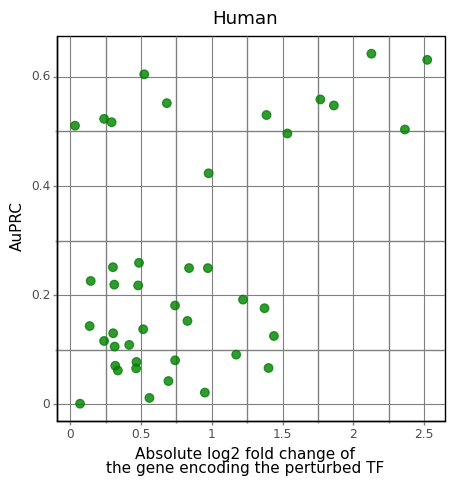

<ggplot: (-9223363248512575586)>

In [16]:
# plot the auprc by absl2fc
theme_set(theme_bw())
gp = (ggplot(df_tfs_simp,
      aes(x='absl2fc', y='auprc'))
    
      + geom_point(alpha=0.8, color='green',size=3)
      
      + labs(title='Human',
             x='Absolute log2 fold change of\nthe gene encoding the perturbed TF',
             y='AuPRC')
      
      + theme_bw() +
        theme(line=element_line(color="gray"),
              axis_line=element_line(color="black"),
              axis_ticks=element_line(color = "black"),
              figure_size=(5,5),
              panel_border=element_line(color="black"))
     )

gp

# "Net Influence" SHAP value plot for USF2 (ENSG00000105698)

In [21]:
# TFs with absl2fc > 1.5
big_lfc = df_tfs_simp[df_tfs_simp['absl2fc'] > 1.5].reset_index()

# list of TFs with absl2fc > 1.5
genes = big_lfc['tf_ensg'].tolist()
genes

['ENSG00000130522',
 'ENSG00000143390',
 'ENSG00000074219',
 'ENSG00000197905',
 'ENSG00000198176',
 'ENSG00000105698']

# LOAD DATA

## MODEL INPUT

### SHAP VALUES (`shapd_df`)

In [32]:
shaps_df = parse_classifier_shap(dirpath, ['ENSG00000105698'], algo, 'all_feats', human_name_dict)
shaps_df

['ENSG00000105698']
ENSG00000105698


,tf,gene,feat_idx,feat,cv
0,ENSG00000105698,ENSG00000000005,0,0.000000,0
1,ENSG00000105698,ENSG00000000457,0,0.000000,0
2,ENSG00000105698,ENSG00000000460,0,0.000000,0
3,ENSG00000105698,ENSG00000002587,0,0.000000,0
4,ENSG00000105698,ENSG00000003137,0,0.000000,0
...,...,...,...,...,...
19922771,ENSG00000105698,ENSG00000276600,1051,-0.476827,9
19922772,ENSG00000105698,ENSG00000277972,1051,0.312653,9
19922773,ENSG00000105698,ENSG00000278540,1051,-0.047317,9
19922774,ENSG00000105698,ENSG00000278677,1051,0.702985,9


### FEATURE MATRIX (`feat_mtx_df`) of single TF (USF2)

> TODO: UPDATE `parse_classifier_feat` TO TAKE IN LIST OF TF'S AS ARGUMENT AND RETURN DATAFRAME OF MULTIPLE TFS FEATURE MATRICES

In [33]:
# feature matrix for single TF
feat_mtx_df = parse_classifier_feat(dirpath, ['ENSG00000105698'], algo, 'all_feats', human_name_dict)
feat_mtx_df

['ENSG00000105698']
(0, 1052)
ENSG00000105698
(18938, 1052)
(18938, 1052)


,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat1042,feat1043,feat1044,feat1045,feat1046,feat1047,feat1048,feat1049,feat1050,feat1051
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.119690,0.060242,0.114319,0.098633,0.013069,0.099243,0.035187,0.057983,1.792392,0.043638
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.104004,0.052368,0.098633,0.072021,0.003626,0.083008,0.029633,0.047638,0.301030,0.239432
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.077454,0.035461,0.080872,0.068115,0.017609,0.066101,0.035004,0.029160,4.805038,-0.000185
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.099915,0.049225,0.092285,0.073791,0.010750,0.083496,0.031555,0.044647,3.551694,-0.037481
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.093445,0.048126,0.087463,0.064087,0.007130,0.078918,0.026550,0.043152,4.257006,0.001709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.043121,0.017868,0.046112,0.050873,0.008873,0.036499,0.021744,0.012375,0.301030,0.061091
18934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.126099,0.040955,0.120361,0.111206,0.010635,0.101074,0.045715,0.031342,1.716003,0.113645
18935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.056000,0.014503,0.059265,0.069519,0.013748,0.042999,0.033264,0.008247,0.301030,0.052958
18936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.118225,0.031250,0.122742,0.141479,0.023254,0.098022,0.053497,0.020996,0.301030,-0.806609


### PREDICTIONS (`preds_df`)

In [34]:
file = '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb_CPU/all_feats/xgb/ENSG00000105698/preds.csv.gz'
preds_df = pd.read_csv(file, header=0)
preds_df

,gene,cv,label,pred
0,ENSG00000000005,0,0,0.051743
1,ENSG00000000457,0,0,0.097568
2,ENSG00000000460,0,1,0.319644
3,ENSG00000002587,0,1,0.170498
4,ENSG00000003137,0,1,0.302523
...,...,...,...,...
18933,ENSG00000276600,9,0,0.152091
18934,ENSG00000277972,9,0,0.574487
18935,ENSG00000278540,9,0,0.209999
18936,ENSG00000278677,9,0,0.435073


### LIST OF GENES (`genes_df`)

In [35]:
file = '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb_CPU/all_feats/xgb/ENSG00000105698/genes.csv.gz'
genes_df = pd.read_csv(file, header=None, names=['gene'])
genes_df

,gene
0,ENSG00000000003
1,ENSG00000000005
2,ENSG00000000419
3,ENSG00000000457
4,ENSG00000000460
...,...
18933,ENSG00000282419
18934,ENSG00000282608
18935,ENSG00000282815
18936,ENSG00000282872


## PROCESSING

### join `feat_mtx_df` with `genes_df`

In [36]:
# add respective genes to feature matrix
feat_mtx_resp_df = feat_mtx_df.copy()
feat_mtx_resp_df.index = genes_df['gene']

In [37]:
# remove non-responsive genes
feat_mtx_resp_df = feat_mtx_resp_df[feat_mtx_resp_df.index.isin(responsive_targets_df['gene_ensg'])]
feat_mtx_resp_df

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat1042,feat1043,feat1044,feat1045,feat1046,feat1047,feat1048,feat1049,feat1050,feat1051
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000000460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.093445,0.048126,0.087463,0.064087,0.007130,0.078918,0.026550,0.043152,4.257006,0.001709
ENSG00000000938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.093506,0.022858,0.088440,0.116211,0.014175,0.076477,0.037842,0.016144,0.301030,-0.016554
ENSG00000001631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.108521,0.057800,0.103455,0.080933,0.016632,0.088684,0.036194,0.058014,4.495572,0.008551
ENSG00000002330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.092590,0.016708,0.077820,0.148926,0.030106,0.075134,0.052612,0.012421,4.136150,0.040667
ENSG00000002587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.143921,0.043488,0.123657,0.148193,0.034668,0.113403,0.068115,0.040375,0.301030,0.198135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000278558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.088684,0.015343,0.069702,0.114868,0.038483,0.067688,0.060242,0.014671,3.262925,0.274214
ENSG00000280789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.131958,0.023743,0.099487,0.194946,0.041748,0.110779,0.067261,0.018997,4.332883,0.007087
ENSG00000281991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.143799,0.032745,0.126221,0.171997,0.017746,0.114258,0.053497,0.026505,2.978637,0.552656


### AVERAGE SHAP VALUES FOR FEATURES OVER RESPONSIVE TARGET GENES

In [39]:
shap_usf2_df = shaps_df[shaps_df['tf']=='ENSG00000105698'] # grab perturbed USF2 data
shap_usf2_df

,tf,gene,feat_idx,feat,cv
0,ENSG00000105698,ENSG00000000005,0,0.000000,0
1,ENSG00000105698,ENSG00000000457,0,0.000000,0
2,ENSG00000105698,ENSG00000000460,0,0.000000,0
3,ENSG00000105698,ENSG00000002587,0,0.000000,0
4,ENSG00000105698,ENSG00000003137,0,0.000000,0
...,...,...,...,...,...
19922771,ENSG00000105698,ENSG00000276600,1051,-0.476827,9
19922772,ENSG00000105698,ENSG00000277972,1051,0.312653,9
19922773,ENSG00000105698,ENSG00000278540,1051,-0.047317,9
19922774,ENSG00000105698,ENSG00000278677,1051,0.702985,9


In [41]:
# unstack and average
shap_usf2_mean_df = shap_usf2_df[['gene','feat_idx','feat','cv']]
shap_usf2_mean_df = shap_usf2_mean_df.groupby(['gene','feat_idx'], as_index=False)[['feat']].mean()
shap_usf2_mean_df

,gene,feat_idx,feat
0,ENSG00000000003,0,0.000000
1,ENSG00000000003,1,0.000000
2,ENSG00000000003,2,0.000000
3,ENSG00000000003,3,0.000000
4,ENSG00000000003,4,0.000000
...,...,...,...
19922771,ENSG00000283071,1047,0.000000
19922772,ENSG00000283071,1048,0.040827
19922773,ENSG00000283071,1049,0.553514
19922774,ENSG00000283071,1050,-0.649287


In [57]:
# subset of responsive target genes
shap_usf2_mean_resp_df = shap_usf2_mean_df[shap_usf2_mean_df['gene'].isin(responsive_targets_df['gene_ensg'])].reset_index(drop=True)

# pivot
shap_usf2_mean_resp_df = shap_usf2_mean_resp_df.pivot(index='gene', columns='feat_idx', values='feat')

# rename columns from i --> feati
shap_usf2_mean_resp_df.columns = ['feat{}'.format(i) for i in shap_usf2_mean_resp_df.columns]
shap_usf2_mean_resp_df = shap_usf2_mean_resp_df.reset_index(drop=True) # remove index (gene names)

shap_usf2_mean_resp_df

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat1042,feat1043,feat1044,feat1045,feat1046,feat1047,feat1048,feat1049,feat1050,feat1051
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000839,0.011340,-0.000806,-0.149327,0.055135,0.000000,-0.020439,-0.212944,0.485956,0.461785
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.002802,0.012460,-0.002193,0.264860,0.026810,0.000000,-0.018957,0.542077,-0.235552,-0.371286
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000218,0.014546,0.000132,-0.151470,0.043473,0.000588,-0.029260,-0.259231,0.498087,0.685685
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.001229,0.002002,0.000075,0.259139,0.027320,0.000000,0.041151,0.639918,0.658039,0.811673
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000519,0.011479,0.000950,0.185150,0.080453,0.000000,0.040344,-0.260873,-0.597470,0.377272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.001813,0.009419,-0.001429,0.156358,0.037416,0.000658,0.104029,0.581080,0.300603,0.546287
5123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000623,0.008073,-0.000065,0.211607,0.047338,-0.002253,0.063097,0.404853,0.524221,0.623300
5124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000218,0.008125,0.000132,0.215868,0.062040,-0.010484,0.051224,-0.185074,-0.644948,0.307364
5125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.002315,0.012158,-0.000938,-0.136674,0.072441,0.000000,-0.128283,0.452732,-0.620293,0.428610


### SUMMARY PLOT: SUM OF SHAP VALUES FOR FEATURES -- NO FEATURE BINNING 

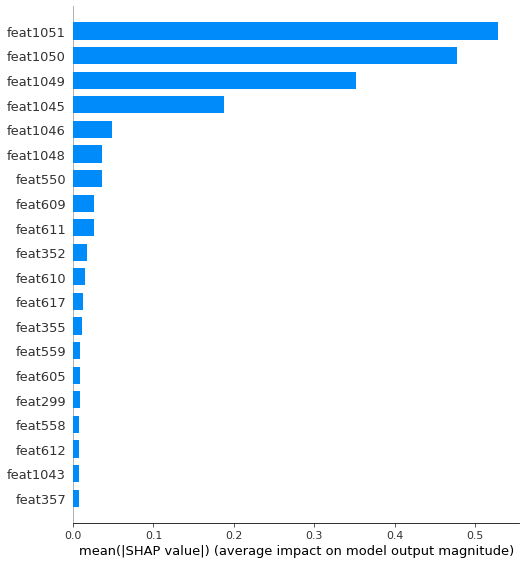

In [58]:
shap.summary_plot(shap_usf2_mean_resp_df.values, feat_mtx_resp_df, plot_type='bar')

## BINNING

### FEATURE BINNING DATA

In [50]:
feats_dir = '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb_CPU/all_feats/xgb/ENSG00000105698/feats.csv.gz'

feats_bin_df = pd.read_csv(feats_dir, header=None, sep=",", names=['feat','subfeat','start','end'])
feats_bin_df

,feat,subfeat,start,end
0,tf_binding,ENSG00000105698,0,130
1,histone_modifications,K562_H3K27ac,130,260
2,histone_modifications,K562_H3K27me3,260,390
3,histone_modifications,K562_H3K36me3,390,520
4,histone_modifications,K562_H3K4me1,520,650
5,histone_modifications,K562_H3K4me3,650,780
6,histone_modifications,K562_H3K9me3,780,910
7,chromatin_accessibility,K562_atac,910,1040
8,dna_sequence_nt_freq,AA,1040,1041
9,dna_sequence_nt_freq,AC,1041,1042


In [54]:
def clean_feats(feats_df):
    idxs = [0,7]
    
    # tf_binding & chrom acc
    for idx in idxs:
        feats_df.loc[idx, 'subfeat'] = feats_df.loc[idx,'feat']
        
    # dinucleotides
    dna = feats_df[feats_df['feat']=='dna_sequence_nt_freq']
    start = dna['start'].values[0]
    end = dna['end'].values[-1]
    
    idx = dna.index[0]
    
    feats_df.loc[idx] = ['dna','Dinucleotides',start,end]
    
    # GEX
    feats_df = feats_df.replace({'median_level':'GEX level', 'variation':'GEX var'})
    
    feats_df = feats_df[feats_df['feat'] != 'dna_sequence_nt_freq']
    
    feats_df = feats_df.drop(columns=['feat']).reset_index(drop=True)
    
    feats_df = feats_df.rename(columns={'subfeat':'feat'})
    
    return feats_df

def group_by_features(feat_df, grouping_df):
    
    df = pd.DataFrame()

    for idx, row in grouping_df.iterrows():

        feat = row['feat']
        start = row['start']
        end = row['end']

        col_names = ['feat{}'.format(i) for i in range(start,end)]

        # sum up respective columns
        sum_feat_col = feat_df[col_names].sum(axis=1)

        # add column to dataset
        df[feat] = sum_feat_col

        # remove columns that were summed
#         feat_df.drop(col_names)

    return df

def group_by_features_abs(feat_df, grouping_df):
    
    df = pd.DataFrame()

    for idx, row in grouping_df.iterrows():

        feat = row['feat']
        start = row['start']
        end = row['end']

        col_names = ['feat{}'.format(i) for i in range(start,end)]

        # sum up respective columns
        sum_feat_col = feat_df[col_names].abs().sum(axis=1)

        # add column to dataset
        df[feat] = sum_feat_col

        # remove columns that were summed
#         feat_df.drop(col_names)

    return df

In [59]:
# clean up feature binning df
clean_feats_bin_df = clean_feats(feats_bin_df)
clean_feats_bin_df

,feat,start,end
0,tf_binding,0,130
1,K562_H3K27ac,130,260
2,K562_H3K27me3,260,390
3,K562_H3K36me3,390,520
4,K562_H3K4me1,520,650
5,K562_H3K4me3,650,780
6,K562_H3K9me3,780,910
7,chromatin_accessibility,910,1040
8,Dinucleotides,1040,1050
9,Dinucleotides,1041,1050


In [65]:
# bin shap matrix features
shap_bin_df = group_by_features(shap_usf2_mean_resp_df, clean_feats_bin_df)
shap_bin_df

,tf_binding,K562_H3K27ac,K562_H3K27me3,K562_H3K36me3,K562_H3K4me1,K562_H3K4me3,K562_H3K9me3,chromatin_accessibility,Dinucleotides,GEX level,GEX var
0,-0.000026,-0.024564,0.107618,-0.007406,-0.144347,0.003986,0.002079,-0.004325,-0.317881,0.485956,0.461785
1,0.000000,0.026122,0.122689,-0.002622,0.218006,-0.008689,-0.094357,0.014668,0.822254,-0.235552,-0.371286
2,-0.000071,0.007112,-0.057997,0.002918,-0.048855,0.017891,0.031373,0.095524,-0.381321,0.498087,0.685685
3,-0.000239,0.009757,-0.016622,-0.007322,0.200570,0.012447,0.002073,0.018974,0.968737,0.658039,0.811673
4,-0.000026,-0.021204,-0.018571,-0.008715,-0.020131,-0.009398,-0.009334,0.001524,0.058021,-0.597470,0.377272
...,...,...,...,...,...,...,...,...,...,...,...
5122,0.000000,-0.007567,-0.059303,-0.004636,-0.168377,-0.010895,0.004433,-0.010548,0.885718,0.300603,0.546287
5123,-0.000071,0.005020,-0.055271,-0.002397,-0.085212,0.018305,-0.000374,0.001155,0.732956,0.524221,0.623300
5124,-0.000071,0.006637,-0.068166,-0.004250,-0.058088,-0.012260,-0.000099,-0.009657,0.141734,-0.644948,0.307364
5125,-0.000026,-0.036365,-0.086728,-0.016897,-0.205825,-0.015197,0.000409,-0.004530,0.269122,-0.620293,0.428610


In [66]:
# bin feature matrix features
feat_mtx_bin_df = group_by_features(feat_mtx_resp_df, clean_feats_bin_df)
feat_mtx_bin_df

,tf_binding,K562_H3K27ac,K562_H3K27me3,K562_H3K36me3,K562_H3K4me1,K562_H3K4me3,K562_H3K9me3,chromatin_accessibility,Dinucleotides,GEX level,GEX var
gene,,,,,,,,,,,
ENSG00000000460,0.00000,2340.205286,328.964048,482.234710,461.071239,2620.095921,397.181891,989.424503,0.512165,4.257006,0.001709
ENSG00000000938,1.97216,521.676828,1175.101183,404.825988,2292.767196,532.271590,400.314588,689.774968,0.523544,0.301030,-0.016554
ENSG00000001631,0.00000,4823.062934,171.623819,480.315797,979.922618,5990.925059,368.042042,1110.007267,0.634338,4.495572,0.008551
ENSG00000002330,0.00000,3779.903981,193.521892,567.199794,4895.200858,5366.598995,130.019528,911.799155,0.557190,4.136150,0.040667
ENSG00000002587,0.00000,36.902610,152.949439,92.461957,179.939742,84.961214,96.071630,144.530071,0.803345,0.301030,0.198135
...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000278558,0.00000,7.215000,0.000000,18.534656,13.814070,11.360187,8.141748,366.223309,0.517288,3.262925,0.274214
ENSG00000280789,0.00000,675.669989,23.701728,123.225335,700.293547,1101.805976,36.373057,163.623269,0.758438,4.332883,0.007087
ENSG00000281991,4.09729,106.122754,31.913311,258.002933,277.030321,43.388202,37.606281,114.593492,0.770508,2.978637,0.552656


### SUMMARY PLOT: MEAN OF SHAP VALUES FOR FEATURES -- WITH  FEATURE BINNING 

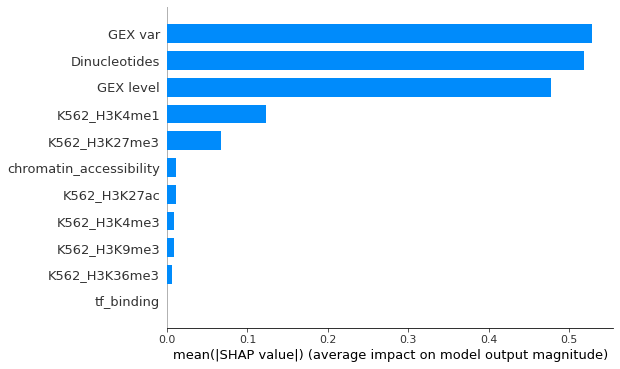

In [68]:
shap.summary_plot(shap_bin_df.values, feat_mtx_bin_df, plot_type='bar')

### PLOT: MEAN OF SHAP VALUES FOR FEATURES -- WITH FEATURE BINNING

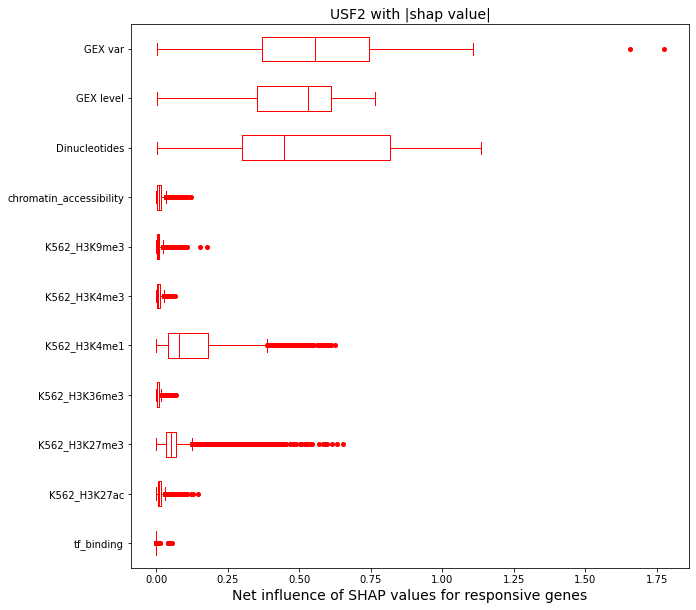

In [109]:
plt.figure(figsize=(10,10))

# flier (aka outlier properties)
flierprops = dict(marker='o', markerfacecolor='r', markersize=4,
                  linestyle='none', markeredgecolor='r')

bp = plt.boxplot(np.abs(shap_bin_df.values), vert=False, labels=shap_bin_df.columns, flierprops=flierprops)

# apply color to all elements of boxplot
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color='r')

# misc labels
plt.title('USF2 with |shap value|', fontsize=14)
plt.xlabel('Net influence of SHAP values for responsive genes', fontsize=14)

plt.show()

## | SHAP VALUE |

In [69]:
# unstack, take abs value, average
shap_usf2_abs_df = shap_usf2_df.copy()

# abs value
shap_usf2_abs_df['absfeat'] = shap_usf2_abs_df.apply(lambda row : abs(row['feat']), axis=1)

# average
shap_usf2_abs_mean_df = shap_usf2_abs_df[['gene','feat_idx','absfeat','cv']]
shap_usf2_abs_mean_df = shap_usf2_abs_mean_df.groupby(['gene','feat_idx'], as_index=False)[['absfeat']].mean()
shap_usf2_abs_mean_df

,gene,feat_idx,absfeat
0,ENSG00000000003,0,0.000000
1,ENSG00000000003,1,0.000000
2,ENSG00000000003,2,0.000000
3,ENSG00000000003,3,0.000000
4,ENSG00000000003,4,0.000000
...,...,...,...
19922771,ENSG00000283071,1047,0.000000
19922772,ENSG00000283071,1048,0.040827
19922773,ENSG00000283071,1049,0.553514
19922774,ENSG00000283071,1050,0.649287


In [71]:
# subset of responsive target genes
shap_usf2_abs_mean_resp_df = shap_usf2_abs_mean_df[shap_usf2_abs_mean_df['gene'].isin(responsive_targets_df['gene_ensg'])].reset_index(drop=True)

# pivot
shap_usf2_abs_mean_resp_df = shap_usf2_abs_mean_resp_df.pivot(index='gene', columns='feat_idx', values='absfeat')

# rename columns from i --> feati
shap_usf2_abs_mean_resp_df.columns = ['feat{}'.format(i) for i in shap_usf2_abs_mean_resp_df.columns]
shap_usf2_abs_mean_resp_df = shap_usf2_abs_mean_resp_df.reset_index(drop=True) # remove index (gene names)

shap_usf2_abs_mean_resp_df

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat1042,feat1043,feat1044,feat1045,feat1046,feat1047,feat1048,feat1049,feat1050,feat1051
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000839,0.011340,0.000806,0.149327,0.055135,0.000000,0.020439,0.212944,0.485956,0.461785
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002802,0.012460,0.002193,0.264860,0.026810,0.000000,0.018957,0.542077,0.235552,0.371286
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000218,0.014546,0.000132,0.151470,0.043473,0.000588,0.029260,0.259231,0.498087,0.685685
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001229,0.002002,0.000075,0.259139,0.027320,0.000000,0.041151,0.639918,0.658039,0.811673
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000519,0.011479,0.000950,0.185150,0.080453,0.000000,0.040344,0.260873,0.597470,0.377272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001813,0.009419,0.001429,0.156358,0.037416,0.000658,0.104029,0.581080,0.300603,0.546287
5123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000623,0.008073,0.000065,0.211607,0.047338,0.002253,0.063097,0.404853,0.524221,0.623300
5124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000218,0.008125,0.000132,0.215868,0.062040,0.010484,0.051224,0.185074,0.644948,0.307364
5125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002315,0.012158,0.000938,0.136674,0.072441,0.000000,0.128283,0.452732,0.620293,0.428610


In [72]:
# bin features
shap_abs_bin_df = group_by_features(shap_usf2_abs_mean_resp_df, clean_feats_bin_df)
shap_abs_bin_df

,tf_binding,K562_H3K27ac,K562_H3K27me3,K562_H3K36me3,K562_H3K4me1,K562_H3K4me3,K562_H3K9me3,chromatin_accessibility,Dinucleotides,GEX level,GEX var
0,0.000026,0.044571,0.210008,0.017130,0.213894,0.011821,0.007030,0.012636,0.450830,0.485956,0.461785
1,0.000000,0.030119,0.221716,0.008824,0.279900,0.022064,0.097975,0.047031,0.870160,0.235552,0.371286
2,0.000071,0.021812,0.058364,0.004416,0.097089,0.019732,0.037695,0.102900,0.499233,0.498087,0.685685
3,0.000239,0.019514,0.055721,0.009384,0.295172,0.018708,0.006722,0.030248,0.971195,0.658039,0.811673
4,0.000026,0.036734,0.094519,0.011409,0.091187,0.010575,0.013422,0.010214,0.579768,0.597470,0.377272
...,...,...,...,...,...,...,...,...,...,...,...
5122,0.000000,0.022470,0.064327,0.016542,0.196765,0.012373,0.006754,0.028181,0.892201,0.300603,0.546287
5123,0.000071,0.012971,0.056750,0.003674,0.118838,0.021446,0.003158,0.016862,0.738224,0.524221,0.623300
5124,0.000071,0.012296,0.077081,0.004544,0.091294,0.014329,0.003464,0.011760,0.533483,0.644948,0.307364
5125,0.000026,0.045203,0.088821,0.018749,0.219743,0.018929,0.005816,0.015878,0.805540,0.620293,0.428610


### SUMMARY PLOT: MEAN OF ABS SHAP VALUES FOR FEATURES -- WITH  FEATURE BINNING 

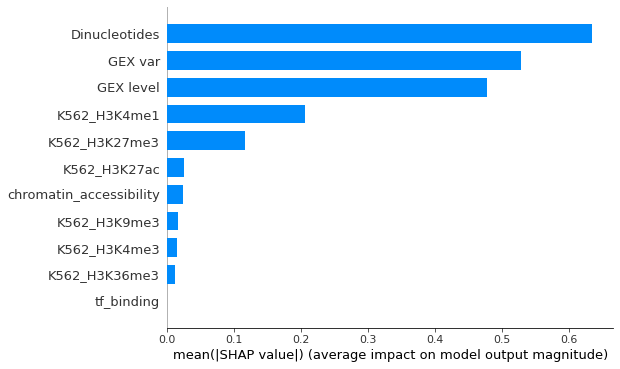

In [74]:
shap.summary_plot(shap_abs_bin_df.values, feat_mtx_bin_df, plot_type='bar')

### PLOT: MEAN OF ABS SHAP VALUES FOR FEATURES -- WITH  FEATURE BINNING 

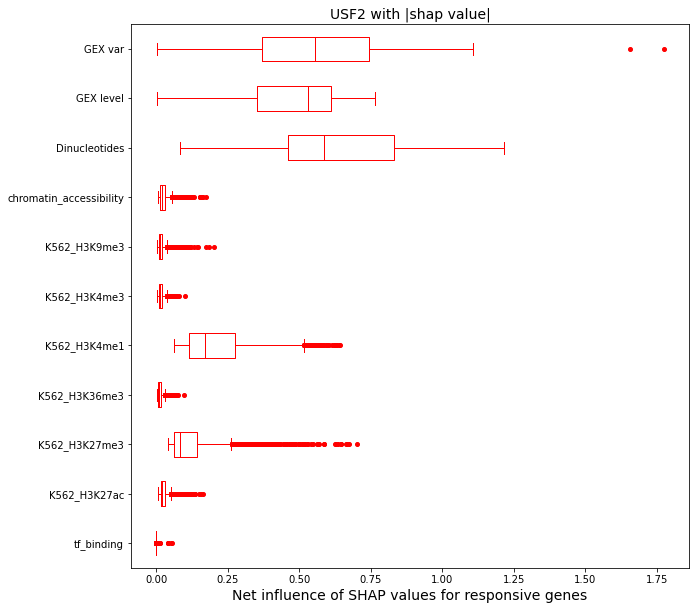

In [104]:
plt.figure(figsize=(10,10))

# flier (aka outlier properties)
flierprops = dict(marker='o', markerfacecolor='r', markersize=4,
                  linestyle='none', markeredgecolor='r')

bp = plt.boxplot(shap_abs_bin_df, vert=False, labels=shap_abs_bin_df.columns, flierprops=flierprops)

# apply color to all elements of boxplot
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color='r')

# misc labels
plt.title('USF2 with |shap value|', fontsize=14)
plt.xlabel('Net influence of SHAP values for responsive genes', fontsize=14)

plt.show()